In [1]:
import string
import re
import pandas as pd
import numpy as np
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.tokenize import word_tokenize
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report,accuracy_score
import string 

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer


[nltk_data] Downloading package punkt to /Users/showjoo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/showjoo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


##### Read IMDB Dataset

In [2]:
imdb_data = pd.read_csv('./data/IMDB Dataset.csv')
imdb_data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


##### Split the IMDB data

In [3]:
train_reviews=imdb_data.review[:30000]
train_sentiments=imdb_data.sentiment[:30000]

val_reviews=imdb_data.review[30000:40000]
val_sentiments=imdb_data.sentiment[30000:40000]

test_reviews=imdb_data.review[40000:]
test_sentiments=imdb_data.sentiment[40000:]

##### Read Yelp Data

In [4]:
# Todo
yelp_data = pd.read_csv('./data/train.csv',header=None,names=["sentiment","review"])
yelp_data = yelp_data.sample(frac=1).reset_index(drop=True) #shuffle
yelp_data.head()

,sentiment,review
0,1,"Without being over the top here, I have a feel..."
1,1,I ate here mainly for convenience sake because...
2,2,The food here was awesome and the service was ...
3,1,I got married here at the beginning of the yea...
4,2,"What a great concept, They successfully manage..."


##### Split Yelp Data

In [5]:
yelp_data['sentiment'].replace(1,'negative',inplace=True)
yelp_data['sentiment'].replace(2,'positive',inplace=True)

train_reviews=yelp_data.review[:30000]
train_sentiments=yelp_data.sentiment[:30000]

val_reviews=yelp_data.review[30000:40000]
val_sentiments=yelp_data.sentiment[30000:40000]

test_reviews=yelp_data.review[40000:50000]
test_sentiments=yelp_data.sentiment[40000:50000]

##### Preprocess Dataset

In [6]:
def preprocess(reviews):
    container = []
    for review in reviews:
        review = review.replace("<br />", "")
        for ele in string.punctuation:
                if ele in review:
                        review = review.replace(ele, "")
        container.append(review)
    return container

def preprocess_sentiment(sentiments):
    container = []
    for sentiment in sentiments:
        container.append(sentiment)
    return container

In [7]:
train_reviews = preprocess(train_reviews)
val_reviews = preprocess(val_reviews)
test_reviews = preprocess(test_reviews)
train_sentiments = preprocess_sentiment(train_sentiments)
val_sentiments = preprocess_sentiment(val_sentiments)
test_sentiments = preprocess_sentiment(test_sentiments)

##### Naive Bayes Model Train

In [8]:
'''
Method that take in the training dataset, then return the positive and negative words log probability.
Input: train_reviews: reviews (sentences) for training
       train_sentiments: sentiments (label) for training
       val_reviews: reviews (sentences) for validation
       test_reviews: reviews (sentences) for testing
       tfidf: boolean variable indicating whether using bow or tfidf
       alpha: laplance smoothing variable, default to be 1.0
       ngram_range: the scale of ngram model will be used, default = (1,1) unigram
return: negative_word_log_prob_dict: dictionary that contains the word:log probability pair for negative class
        positive_word_log_prob_dict: dictionary that contains the word:log probability pair for positive class
        mnb: the trained multinomial naive bayes model, later can be used for testing
        transformed_val_reviews: transformed val reviews that later can be used for validation
        transformed_test_reviews: transformed test reviews that later can be used for testing
        vec: either the tfidfVectorize build from tfidf model or the CountVectorizer build from Bag of word model.
'''

def generate_log_prob(train_reviews, train_sentiments,  test_reviews, val_reviews=None, tfidf=False, alpha=1.0, ngram_range = (1,1)):

    if (tfidf):
        #Tfidf vectorizer
        vec=TfidfVectorizer(use_idf=tfidf, ngram_range=ngram_range)
        transformed_train_reviews=vec.fit_transform(train_reviews)
        if val_reviews is not None:
            transformed_val_reviews = vec.transform(val_reviews)
        transformed_test_reviews=vec.transform(test_reviews)
    else:
        vec=CountVectorizer(ngram_range=(1,1))
        transformed_train_reviews=vec.fit_transform(train_reviews)
        if val_reviews is not None:
            transformed_val_reviews = vec.transform(val_reviews)
        transformed_test_reviews=vec.transform(test_reviews)

    #training the model
    mnb = MultinomialNB(alpha=alpha)

    #fitting the naive bayes for bag of words
    mnb = mnb.fit(transformed_train_reviews, train_sentiments)
    
    negative_log_prob = mnb.feature_log_prob_[0]
    positive_log_prob = mnb.feature_log_prob_[1]

    # Generate two dict: word:log_prob
    negative_word_log_prob_dict = {}
    positive_word_log_prob_dict = {}
    for word, index in vec.vocabulary_.items():
        negative_word_log_prob_dict[word] = negative_log_prob[index]
        positive_word_log_prob_dict[word] = positive_log_prob[index]
    if val_reviews is None:
        return negative_word_log_prob_dict, positive_word_log_prob_dict, mnb, transformed_test_reviews, vec
    else:
        return negative_word_log_prob_dict, positive_word_log_prob_dict, mnb, transformed_val_reviews, transformed_test_reviews, vec 

##### Naive Bayes Model Inference

In [9]:
def naive_inference(reweight, pos, neg, unseen_pos, unseen_neg, test_reviews, test_sentiments):
    correct = 0
    prediction = []
    pattern = r'[^A-Za-z0-9]+'
    for i in range(len(test_reviews)):
        word_list = test_reviews[i]
        word_list = re.sub(pattern, " ", word_list.lower()).split()
        # word_list = test_reviews[i].strip().lower().split()
        final_result = 0
        
        for word in word_list:
            weight = 1
            pprob = unseen_pos
            nprob = unseen_neg
            if word in reweight:
                weight = reweight[word]
            if word in pos:
                pprob = pos[word]
            if word in neg:
                nprob = neg[word]
            final_result += weight*pprob - weight*nprob
        if final_result > 0:
            prediction.append("positive")
        elif final_result < 0:
            prediction.append("negative")
        if (final_result > 0 and test_sentiments[i] == "positive") or (final_result < 0 and test_sentiments[i] == "negative"):
            correct += 1
    return prediction, correct/len(test_reviews)

##### Reweight by Count Algorithm

In [10]:
from collections import defaultdict

def classify(positive_dict,negative_dict,count_dict:defaultdict,transformed_valid_reviews,valid_sentiments,vec,wrong_label):
    rows = np.nonzero(transformed_valid_reviews)[0]
    columns = np.nonzero(transformed_valid_reviews)[1]
    indices = zip(rows,columns)
    # start_index = valid_sentiments.index.start
    # find word using index
    reverse_vec = {k:v for v,k in vec.vocabulary_.items()}
    #travase - only wrong case
    if wrong_label:
        indices = filter(lambda index:index[0] in wrong_label,indices)
        for row,column in indices:
            label = valid_sentiments[row]
            word = reverse_vec[column]
            count = transformed_valid_reviews[row,column]
            #compare
            if label == 'positive':
                #起正作用情况
                if positive_dict[word] > negative_dict[word]:
                    count_dict[word]['good'] += count
                #起负作用情况
                elif positive_dict[word] < negative_dict[word]:
                    count_dict[word]['bad'] += count
            elif label == 'negative':
                #起正作用情况
                if positive_dict[word] < negative_dict[word]:
                    count_dict[word]['good'] += count
                #起负作用情况
                elif positive_dict[word] > negative_dict[word]:
                    count_dict[word]['bad'] += count
    else: # all case
        for row,column in indices:
            label = valid_sentiments[row]
            word = reverse_vec[column]
            count = transformed_valid_reviews[row,column]
            #compare
            if label == 'positive':
                #起正作用情况
                if positive_dict[word] > negative_dict[word]:
                    count_dict[word]['good'] += count
                #起负作用情况
                elif positive_dict[word] < negative_dict[word]:
                    count_dict[word]['bad'] += count
            elif label == 'negative':
                #起正作用情况
                if positive_dict[word] < negative_dict[word]:
                    count_dict[word]['good'] += count
                #起负作用情况
                elif positive_dict[word] > negative_dict[word]:
                    count_dict[word]['bad'] += count        
    return count_dict
def reweight_count_wrong(positive_dict,negative_dict,transformed_valid_reviews,valid_sentiments,vec,wrong_label = []) -> dict:
    count_dict = defaultdict(lambda: defaultdict(int))
    count_dict = classify(positive_dict,negative_dict,count_dict,transformed_valid_reviews,valid_sentiments,vec,wrong_label)
    #initialize reweight_dict
    #reweight_dict = defaultdict(lambda: 1)
    #filter bad > good, hyperparameter - set 怎么算要reweight
    new_count_dict = {i:count_dict[i] for i in filter(lambda k:count_dict[k]['bad'] > count_dict[k]['good'],count_dict.keys())}
    #return count_dict, hyperparameter - set reweight成多少
    #transfer to bad+good/bad-good
    transfer_count_dict = {k:(new_count_dict[k]['bad'] + new_count_dict[k]['good'])/(new_count_dict[k]['bad'] - new_count_dict[k]['good']) for k in new_count_dict.keys()}
    #normalization
    d_range = max(transfer_count_dict.values()) -min(transfer_count_dict.values())
    d_min = min(transfer_count_dict.values())
    test_reweight_dict = {k:(v-d_min)/d_range for k,v in transfer_count_dict.items()}
    return test_reweight_dict,count_dict

##### Reweight by Value Algorithm

In [11]:
def calculate_reweight_dict(pos, neg, dataset, threshold=0.1):
    wrongly_classified_dict = {} # counts how many times a token has negative impact on wrongly classified sentence
    token_dict = {} # counts how many times a token has appeared in total
    reweight_dict = {}
    for label, sentence in dataset:
        real_label = label
        tokens = sentence
        for token in tokens:
            if token not in token_dict:
                token_dict[token] = 1
            else:
                token_dict[token] += 1
        if real_label == "positive": # marked as negative
            for token in tokens:
                if token not in pos: continue
                elif pos[token] < neg[token]:
                    if token not in wrongly_classified_dict:
                        wrongly_classified_dict[token] = 1
                    else:
                        wrongly_classified_dict[token] += 1
        elif real_label == "negative": # marked as positive
            for token in tokens:
                if token not in pos: continue
                elif neg[token] < pos[token]:
                    if token not in wrongly_classified_dict:
                        wrongly_classified_dict[token] = 1
                    else:
                        wrongly_classified_dict[token] += 1
    for word, prob in wrongly_classified_dict.items():
        weight = 0
        if pos[word] < neg[word]:
            weight = pos[word] - neg[word]
        elif neg[word] < pos[word]:
            weight = neg[word] - pos[word]
        multiplier = 1 - wrongly_classified_dict[word] / token_dict[word]
        if multiplier == 0:
            reweight_dict[word] = 0
        else:
            reweight_dict[word] = np.exp(weight) * multiplier
    return reweight_dict

##### Perceptron Reweighting Algorithm

In [12]:
def perceptron_update(positive_prob_dict, negative_prob_dict, unseen_pos, unseen_neg, val_reviews, val_sentiments, test_reviews, test_sentiments, max_iter=10, learning_rate=0.02):
    """
    need to handle unseen word here
    has to be a method
    """
    initial_weight = {}
    for i in range(max_iter):
        random_array = np.arange(len(val_sentiments))
        np.random.shuffle(random_array)
        correct = 0
        for index in random_array:
            word_list = val_reviews[index]
            word_list = re.sub(pattern, " ", word_list.lower()).split()
            final_result = 0
            for word in word_list:
                weight = 1
                pprob = unseen_pos
                nprob = unseen_neg
                if word not in initial_weight:
                    initial_weight[word] = 1
                if word in initial_weight:
                    weight = initial_weight[word]
                if word in positive_prob_dict:
                    pprob = positive_prob_dict[word]
                if word in negative_prob_dict:
                    nprob = negative_prob_dict[word]
                final_result += weight*pprob - weight*nprob
            if (final_result > 0 and val_sentiments[index] == "positive") or (final_result < 0 and val_sentiments[index] == "negative"):
                correct += 1
                for word in word_list:
                    initial_weight[word] -= learning_rate/len(val_sentiments)*initial_weight[word]
            else:
                for word in word_list:
                    pprob = unseen_pos
                    nprob = unseen_neg
                    if word in positive_prob_dict:
                        pprob = positive_prob_dict[word]
                    if word in negative_prob_dict:
                        nprob = negative_prob_dict[word]
                    if val_sentiments[index] == "positive":
                        initial_weight[word] += learning_rate*((pprob-nprob) - 1/len(val_sentiments)*initial_weight[word])
                    else:
                        initial_weight[word] += learning_rate*((nprob-pprob) - 1/len(val_sentiments)*initial_weight[word])
        test_pred, test_acc = naive_inference(initial_weight, positive_prob_dict, negative_prob_dict, unseen_pos, unseen_neg, test_reviews, test_sentiments)
        val_accuracy = correct/len(val_sentiments)
        print(f"finish training epoch {i}, the val accuracy is {val_accuracy}, the test accuracy is {test_acc}")
        
    return initial_weight, val_accuracy, test_acc

##### Running - Training

In [24]:
neg, pos, mnb, transformed_val_reviews, transformed_test_reviews, vec= generate_log_prob(train_reviews, train_sentiments, test_reviews, val_reviews=val_reviews, alpha = 1)
unseen_neg = mnb.feature_log_prob_[0].min()
unseen_pos = mnb.feature_log_prob_[1].min()
print(unseen_neg, unseen_pos)

-14.615105213227967 -14.34701665889759


##### Running - Baseline Inference

In [25]:
val_pred_baseline, val_acc_baseline = naive_inference({}, pos, neg, unseen_pos, unseen_neg, val_reviews, val_sentiments)
test_pred_baseline, test_acc_baseline = naive_inference({}, pos, neg, unseen_pos, unseen_neg, test_reviews, test_sentiments)
print(f"val accuracy is {val_acc_baseline}, test accuracy is {test_acc_baseline}")


val accuracy is 0.864, test accuracy is 0.8567


##### Running - Count Reweight Inference

In [15]:
# Todo
reweight_dict_count, _ = reweight_count_wrong(pos, neg, transformed_val_reviews, val_sentiments, vec)
val_pred_count, val_acc_count = naive_inference(reweight_dict_count, pos, neg, unseen_pos, unseen_neg, val_reviews, val_sentiments)
test_pred_count, test_acc_count = naive_inference(reweight_dict_count, pos, neg, unseen_pos, unseen_neg, test_reviews, test_sentiments)
print(f"val accuracy is {val_acc_count}, test accuracy is {test_acc_count}")

val accuracy is 0.8914, test accuracy is 0.8659


##### Running - Value Reweight Inference

In [26]:
wrong_labeled = []
pattern = r'[^A-Za-z0-9]+'

for i in range(len(val_reviews)):
    start_index = 30000
    if(val_pred_baseline[i] != val_sentiments[i]):
        sentiment = val_sentiments[i]
        review = str(yelp_data['review'][start_index + i])
        #review = str(imdb_data['review'][start_index + i])
        review = re.sub(pattern, " ", review.lower()).split()
        wrong_labeled.append((sentiment, review))

reweight_dict_value = calculate_reweight_dict(pos, neg, wrong_labeled)
val_pred_value, val_acc_value = naive_inference(reweight_dict_value, pos, neg, unseen_pos, unseen_neg, val_reviews, val_sentiments)
test_pred_value, test_acc_value = naive_inference(reweight_dict_value, pos, neg, unseen_pos, unseen_neg, test_reviews, test_sentiments)
print(f"val accuracy is {val_acc_value}, test accuracy is {test_acc_value}")

val accuracy is 0.8781, test accuracy is 0.8375


##### Running - Perceptron Reweight Inference

In [18]:
reweight, val_acc_perceptron, test_acc_perceptron = perceptron_update(pos, neg, unseen_pos, unseen_neg, val_reviews, val_sentiments, test_reviews, test_sentiments)

finish training epoch 0, the val accuracy is 0.8859, the test accuracy is 0.891
finish training epoch 1, the val accuracy is 0.9048, the test accuracy is 0.8954
finish training epoch 2, the val accuracy is 0.91, the test accuracy is 0.8951
finish training epoch 3, the val accuracy is 0.9176, the test accuracy is 0.8954
finish training epoch 4, the val accuracy is 0.922, the test accuracy is 0.8946
finish training epoch 5, the val accuracy is 0.926, the test accuracy is 0.8974
finish training epoch 6, the val accuracy is 0.9287, the test accuracy is 0.895
finish training epoch 7, the val accuracy is 0.9322, the test accuracy is 0.8958
finish training epoch 8, the val accuracy is 0.9368, the test accuracy is 0.8941
finish training epoch 9, the val accuracy is 0.9415, the test accuracy is 0.892


##### Record Weight Dict

In [16]:
weight_printed_version = dict(sorted(reweight.items(), key=lambda item: item[1]))
with open("weight_dict.txt", "w") as f:
    for k, v in weight_printed_version.items():
        f.write(str(k))
        f.write(": ")
        f.write(str(v))
        f.write('\n')


In [17]:
import pickle

with open('weight.pickle', 'wb') as handle:
    pickle.dump(reweight, handle, protocol=pickle.HIGHEST_PROTOCOL)

##### Graphing

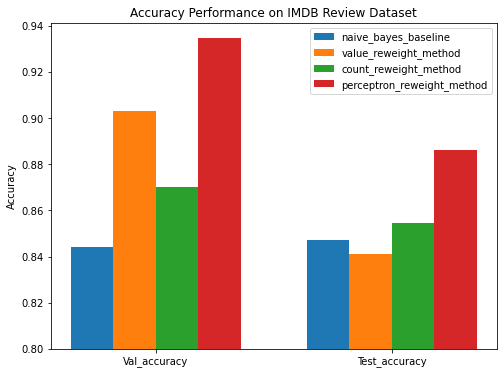

In [22]:
#accuracy analysis
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8, 6))
# 构造x轴刻度标签、数据
labels = ['Val_accuracy', 'Test_accuracy']
naive_bayes_baseline = [0.0441,0.0472]
value_reweight_method = [0.1031,0.041]
count_reweight_method = [0.0702,0.0547]
perceptron_reweight_method = [0.1346,0.0863]

x = np.arange(len(labels))  # x轴刻度标签位置
bottom = 0.8
width = 0.18  # 柱子的宽度
# 计算每个柱子在x轴上的位置，保证x轴刻度标签居中
plt.bar(x - 1.5*width, naive_bayes_baseline, width, bottom, label='naive_bayes_baseline')
plt.bar(x - 0.5*width, value_reweight_method, width, bottom, label='value_reweight_method')
plt.bar(x + 0.5*width, count_reweight_method, width, bottom, label='count_reweight_method')
plt.bar(x + 1.5*width, perceptron_reweight_method, width, bottom, label='perceptron_reweight_method')
plt.ylabel('Accuracy')
plt.title('Accuracy Performance on IMDB Review Dataset')
# x轴刻度标签位置不进行计算
plt.xticks(x, labels=labels)
plt.legend()

plt.savefig('accuracy_imdb.png',bbox_inches = 'tight')
plt.show()

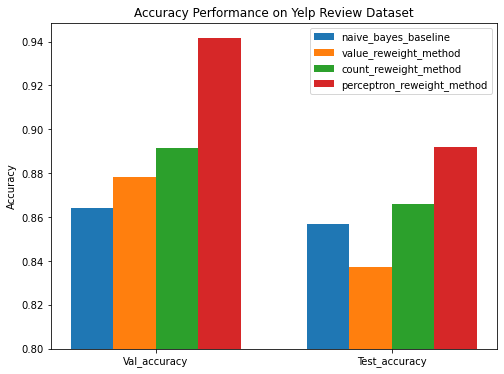

In [27]:
#accuracy analysis
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8, 6))
bottom = 0.8
width = 0.18  # 柱子的宽度
# 构造x轴刻度标签、数据
labels = ['Val_accuracy', 'Test_accuracy']
naive_bayes_baseline = [val_acc_baseline-bottom,test_acc_baseline-bottom]
value_reweight_method = [val_acc_value-bottom,test_acc_value-bottom]
count_reweight_method = [val_acc_count-bottom,test_acc_count-bottom]
perceptron_reweight_method = [val_acc_perceptron-bottom,test_acc_perceptron-bottom]

x = np.arange(len(labels))  # x轴刻度标签位置
# 计算每个柱子在x轴上的位置，保证x轴刻度标签居中
plt.bar(x - 1.5*width, naive_bayes_baseline, width, bottom, label='naive_bayes_baseline')
plt.bar(x - 0.5*width, value_reweight_method, width, bottom, label='value_reweight_method')
plt.bar(x + 0.5*width, count_reweight_method, width, bottom, label='count_reweight_method')
plt.bar(x + 1.5*width, perceptron_reweight_method, width, bottom, label='perceptron_reweight_method')
plt.ylabel('Accuracy')
plt.title('Accuracy Performance on Yelp Review Dataset')
# x轴刻度标签位置不进行计算
plt.xticks(x, labels=labels)
plt.legend()

plt.savefig('accuracy_yelp.png',bbox_inches = 'tight')
plt.show()